In [1]:
import os
import random
import warnings
from functools import reduce
from datetime import datetime
from pathlib import Path
from typing import Union

import gdown
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import seaborn as sns
import squidpy as sq
from matplotlib import gridspec
from sklearn.preprocessing import MinMaxScaler

from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                compute_communication_gp_network,
                                visualize_communication_gp_network,
                                create_new_color_dict,
                                extract_gp_dict_from_mebocost_ms_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps_v2,
                                generate_enriched_gp_info_plots)

from utilities import spatial_subset


/home/ceger/miniforge3/envs/nichecompass_0_2_1-env/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
def create_folders(base_path: str, structure: dict, current_path: Union[str, Path] = None) -> None:
    if current_path is None:
        current_path = Path(base_path)
    Path(current_path).mkdir(exist_ok=True)
    for key, value in structure.items():
        new_path = current_path / str(key)
        if isinstance(value, dict):
            Path(new_path).mkdir(exist_ok=True)
            create_folders(base_path, value, new_path)

In [3]:
notebook_name = "2-NicheCompass.ipynb" 
notebook_path = Path.cwd() / notebook_name
current_timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")


data_folder_path = Path.cwd() / ".." / ".data"
nichecompass_data_path = data_folder_path / "nichecompass" 


In [4]:
create_folders(
    str(nichecompass_data_path),
    {
        "artifacts": {
            notebook_name: {
                current_timestamp: {
                    "model": {},
                    "figures": {},
                }
            }
        },
        "data": {
            "gene_annotations": {},
            "gene_programs": {
                "metabolite_enzyme_sensor_gps": {}
            },
            "spatial_omics": {},
        }
    }
)

View of AnnData object with n_obs × n_vars = 313497 × 1000
    obs: 'bin_count', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg'
    obsm: 'spatial', 'spatial_cropped'


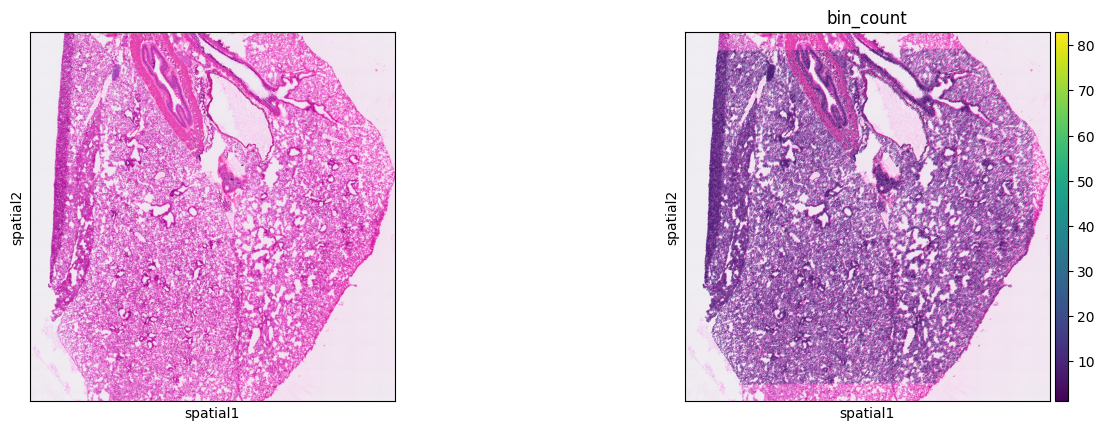

[<Axes: xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'bin_count'}, xlabel='spatial1', ylabel='spatial2'>]

In [10]:
adata = sc.read_h5ad(data_folder_path / "processed" / "preprocessing" / "2024-11-22_16-58-56_VisiumHD_mouse_lung_bin2cell.h5ad")
central_coordinate = (adata.obsm["spatial"][:,0].max() + adata.obsm["spatial"][:,0].min()) / 2, (adata.obsm["spatial"][:,1].max() + adata.obsm["spatial"][:,1].min()) / 2
#adata = spatial_subset(adata, ["circle"], [(central_coordinate, 800)], ["keep"])
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=1000)
adata = adata[:, adata.var["highly_variable"]]
print(adata)
sc.pl.spatial(adata, color=[None, "bin_count"], return_fig=True)

## GP dicts

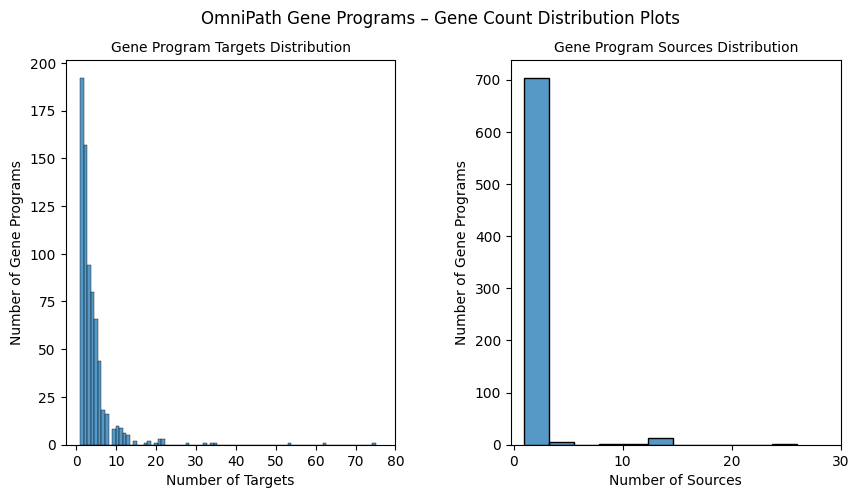

/home/ceger/miniforge3/envs/nichecompass_0_2_1-env/lib/python3.9/site-packages/nichecompass/utils/gene_programs.py:506: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ligand_target_matrix_df.applymap(


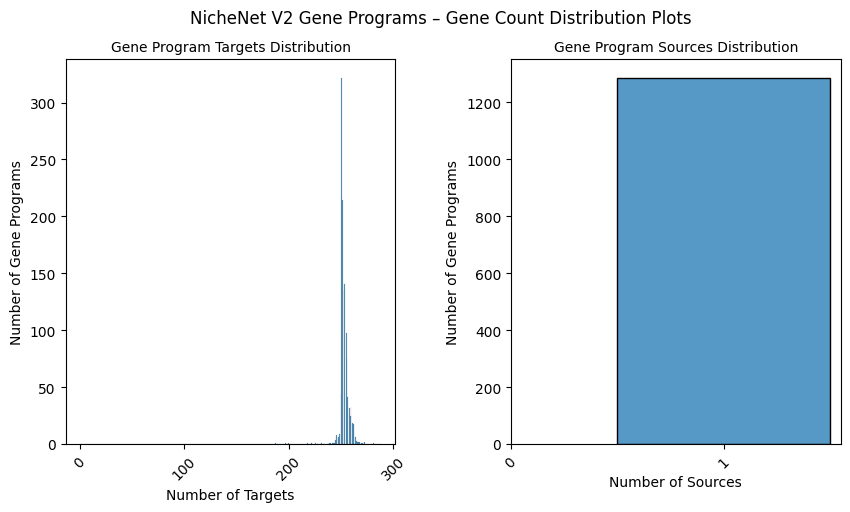

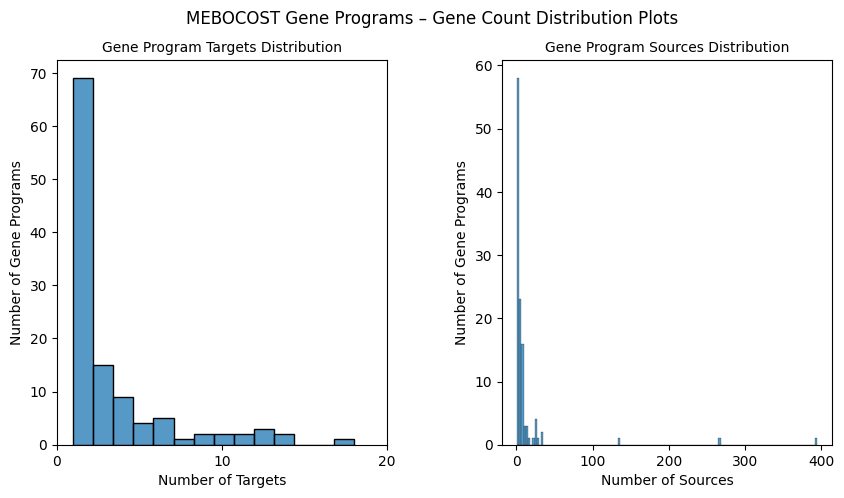

In [6]:
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    species="mouse",
    load_from_disk=False,
    save_to_disk=True,
    lr_network_file_path=nichecompass_data_path / "data" / "gene_programs" / "omnipath_lr_network.csv",
    gene_orthologs_mapping_file_path=nichecompass_data_path / "data" / "gene_annotations" / "human_mouse_gene_orthologs.csv", # Downloaded from the code repo data/gene_annotations
    plot_gp_gene_count_distributions=True,
    gp_gene_count_distributions_save_path=nichecompass_data_path / "artifacts" / notebook_name / current_timestamp / "figures" / "omnipath_gp_gene_count_distributions.svg"
)

nichenet_gp_dict = extract_gp_dict_from_nichenet_lrt_interactions(
    species="mouse",
    version="v2",
    keep_target_genes_ratio=1.,
    max_n_target_genes_per_gp=250,
    load_from_disk=False,
    save_to_disk=True,
    lr_network_file_path=nichecompass_data_path / "data" / "gene_programs" / "nichenet_lr_network_v2_mouse.csv",
    ligand_target_matrix_file_path=nichecompass_data_path / "data" / "gene_programs" / "nichenet_ligand_target_matrix_v2_mouse.csv",
    gene_orthologs_mapping_file_path=nichecompass_data_path / "data" / "gene_annotations" / "human_mouse_gene_orthologs.csv",
    plot_gp_gene_count_distributions=True
)
# Requires downloading mouse_metabolite_enzymes.tsv and mouse_metabolite_sensors.tsv data/gene_programs/metabolite_enzyme_sensor_gps
mebocost_gp_dict = extract_gp_dict_from_mebocost_ms_interactions(
    dir_path=str(nichecompass_data_path / "data" / "gene_programs" / "metabolite_enzyme_sensor_gps"), # This one requires the Path object to be converted to a string
    species="mouse",
    plot_gp_gene_count_distributions=True
)

In [7]:
combined_gp_dict = reduce(lambda d1, d2: {**d1, **d2}, [omnipath_gp_dict, mebocost_gp_dict, nichenet_gp_dict, {}])

combined_new_gp_dict = filter_and_combine_gp_dict_gps_v2(
    gp_dicts=[omnipath_gp_dict, mebocost_gp_dict, nichenet_gp_dict],
)

print("Number of gene programs before filtering and combining: "
      f"{len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: "
      f"{len(combined_new_gp_dict)}.")

Number of gene programs before filtering and combining: 2126.
Number of gene programs after filtering and combining: 1582.


In [8]:
sq.gr.spatial_neighbors(
    adata,
    coord_type="generic",
    spatial_key="spatial",
    n_neighs=4
)
adata.obsp["spatial_connectivities"] = adata.obsp["spatial_connectivities"].maximum(adata.obsp["spatial_connectivities"].T)
adata

/home/ceger/miniforge3/envs/nichecompass_0_2_1-env/lib/python3.9/site-packages/squidpy/gr/_utils.py:194: ImplicitModificationWarning: Setting element `.obsp['spatial_connectivities']` of view, initializing view as actual.
  obj[key] = data


AnnData object with n_obs × n_vars = 313497 × 1000
    obs: 'bin_count', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'spatial_neighbors'
    obsm: 'spatial', 'spatial_cropped'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [9]:
# Add the GP dictionary as binary masks to the adata
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_gp_dict,
    adata=adata,
    gp_targets_mask_key="nichecompass_gp_targets",
    gp_targets_categories_mask_key="nichecompass_gp_targets_categories",
    gp_sources_mask_key="nichecompass_gp_sources",
    gp_sources_categories_mask_key="nichecompass_gp_sources_categories",
    gp_names_key="nichecompass_gp_names",
    min_genes_per_gp=2,
    min_source_genes_per_gp=1,
    min_target_genes_per_gp=1,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None
)

In [12]:
# Initialize model
model = NicheCompass(
    adata,
    counts_key=None,
    adj_key="spatial_connectivities",
    gp_names_key="nichecompass_gp_names",
    active_gp_names_key="nichecompass_active_gp_names",
    gp_targets_mask_key="nichecompass_gp_targets",
    gp_targets_categories_mask_key="nichecompass_gp_targets_categories",
    gp_sources_mask_key="nichecompass_gp_sources",
    gp_sources_categories_mask_key="nichecompass_gp_sources_categories",
    latent_key="nichecompass_latent",
    conv_layer_encoder="gatv2conv",
    active_gp_thresh_ratio=0.01
)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, rna_recon_loss: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.01
LOG VARIATIONAL -> True
ONE HOP GCN NORM RNA NODE LABEL AGGREGATOR
ENCODER -> n_input: 1000, n_cat_covariates_embed_input: 0, n_hidden: 256, n_latent: 156, n_addon_latent: 100, n_fc_layers: 1, n_layers: 1, conv_layer: gatv2conv, n_attention_heads: 4, dropout_rate: 0.0, 
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED TARGET RNA DECODER -> n_prior_gp_input: 156, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 1000
MASKED SOURCE RNA DECODER -> n_prior_gp_input: 156, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 1000


In [13]:
model.train(
    n_epochs=400,
    n_epochs_all_gps=25,
    lr=0.001,
    lambda_edge_recon=500000.0,
    lambda_gene_expr_recon=300.0,
    lambda_l1_masked=0.0,
    edge_batch_size=4096,
    n_sampled_neighbors=4,
    use_cuda_if_available=True,
    verbose=False
)


--- INITIALIZING TRAINER ---


/home/ceger/miniforge3/envs/nichecompass_0_2_1-env/lib/python3.9/site-packages/nichecompass/data/utils.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:651.)
  torch_sparse_coo_tensor = torch.sparse.FloatTensor(indices, values, shape)


Number of training nodes: 282147
Number of validation nodes: 31350
Number of training edges: 672345
Number of validation edges: 74704
Edge batch size: 4096
Node batch size: None

--- MODEL TRAINING ---


/home/ceger/miniforge3/envs/nichecompass_0_2_1-env/lib/python3.9/site-packages/torch_geometric/sampler/neighbor_sampler.py:55: UserWarning: The usage of the 'directed' argument in 'NeighborSampler' is deprecated. Use `subgraph_type='induced'` instead.
  warnings.warn(f"The usage of the 'directed' argument in "


Epoch 1/400 |--------------------| 0.2% train_global_loss: 487113.6981; train_optim_loss: 487113.6981; val_global_loss: 405685.1316; val_optim_loss: 405685.1316


KeyboardInterrupt: 

In [ ]:
# Compute latent neighbor graph
sc.pp.neighbors(model.adata,
                use_rep="nichecompass_latent",
                key_added="nichecompass_latent")

# Compute UMAP embedding
sc.tl.umap(model.adata,
           neighbors_key="nichecompass_latent")

In [ ]:
# Save trained model
model.save(dir_path=nichecompass_data_path / "artifacts" / notebook_name / current_timestamp / "model",
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")